In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt
from random import choices
import time
from datetime import datetime

#----------------------------------------------------------------------------------------
#-----------------------------INTERNAL PARAMETERS----------------------------------------
S = 3000
T = 100
alpha = 0.1
epsilon = 0.3
gamma = 0.0
tau = np.array([0.1, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256])
N = np.size(tau)
l = int(T/4)
REWARDS = np.array([-50,-5,20,10])
THREATS = np.array([-20,-30,-100,-40])
max_reward = np.max(REWARDS)
max_threat = np.max(THREATS)
#----------------------------------------------------------------------------------------
#----------------------------------FUNCTIONS---------------------------------------------

def linear_scalar(Q, w, eps):
    temp = Q[0,:]*w[0] + Q[1,:]*w[1]
    if np.random.uniform(0,1) < eps:
        action = np.random.randint(0,4)
    else:
        action = np.random.choice(np.array(np.where(temp == np.amax(temp))).flatten())
    return action

def softmax_one (Q, w, tau):
    temp = (Q[0,:]*w[0] + Q[1,:]*w[1])/tau 
    ex = np.exp(temp - np.max(temp))
    weights = ex/np.sum(ex)
    population = np.arange(np.size(Q,1))
    action = choices(population, weights)
    return action[0]

def softmax_two (Q, w, tau):
    ex_zero =  np.exp((Q[0,:] - np.max(Q[0,:]))/tau)
    weights_zero = ex_zero/np.sum(ex_zero)
    ex_one =  np.exp((Q[1,:] - np.max(Q[1,:]))/tau)
    weights_one = ex_one/np.sum(ex_one)
    weights = w[0]*weights_zero + w[1]*weights_one
    population = np.arange(np.size(Q,1))
    action = choices(population, weights)
    return action[0]

# choosing argmax over Q is put here explicitly as Amy suggested
def update(curr_action, Q, reward, obj):
    target = Q[obj,curr_action]
    greedy_action = np.random.choice(np.array(np.where(Q[obj,:] == np.amax(Q[obj,:]))).flatten())
    predict = reward + gamma*Q[obj, greedy_action]
    Q[obj, curr_action] = (1-alpha)*target + alpha*predict

def step(curr_action):
    return REWARDS[curr_action], THREATS[curr_action]

#----------------------------------------------------------------------------------------------------
#----------------------------------------TRAINING----------------------------------------------------
p = 0.04
W = int(1/p) + 1

# recording all action sequences will be enough to recover the complete process
# this is done to potenially save up time and space
Q = np.zeros((S,2,4,W,N))
actions = np.zeros((S,T,W,N))

start = datetime.today()  # Get timezone naive now
start_seconds = start.timestamp()

for n in range(N):
    print(n)
    print("tau = ", tau[n])
    for w in range(W):
        weight = [p*w, 1.0 - p*w]
        for s in range(S):
            for t in range(T):
                curr_action = softmax_one(Q[s,:,:,w,n], weight, tau[n])
                reward, threat = step(curr_action)
                actions[s,t,w,n] =  curr_action
                update(curr_action, Q[s,:,:,w,n], reward, 0)
                update(curr_action, Q[s,:,:,w,n], threat, 1)
end = datetime.today()
end_seconds = end.timestamp()
print("execution time = ", end_seconds - start_seconds, "s")

0
tau =  0.1
1
tau =  0.5
2
tau =  1.0
3
tau =  2.0
4
tau =  4.0
5
tau =  8.0
6
tau =  16.0
7
tau =  32.0
8
tau =  64.0
9
tau =  128.0
10
tau =  256.0
execution time =  5072.281985998154 s


In [2]:
regret = max_reward - REWARDS
print("pure reward regrets", regret)

thr_regret = max_threat - THREATS
print("pure threat regret ", thr_regret)

K = 100
reward_regret = np.zeros((S,K,W,N))
threat_regret = np.zeros((S,K,W,N))
for n in range(N):
    for w in range(W):
        for s in range(S):
            for k in range(K):
                a = int(actions[s,-k,w,n])
                reward_regret[s,k,w,n] = max_reward - REWARDS[a]
                threat_regret[s,k,w,n] = max_threat - THREATS[a]
#------the tail average regrets to be plotted are computed below-------
ave_reward_regret = np.mean(reward_regret, axis = (0,1))
ave_threat_regret = np.mean(threat_regret, axis = (0,1))
print(np.shape(ave_reward_regret))
print(np.shape(ave_threat_regret))

pure reward regrets [70 25  0 10]
pure threat regret  [ 0 10 80 20]
(26, 11)
(26, 11)


11


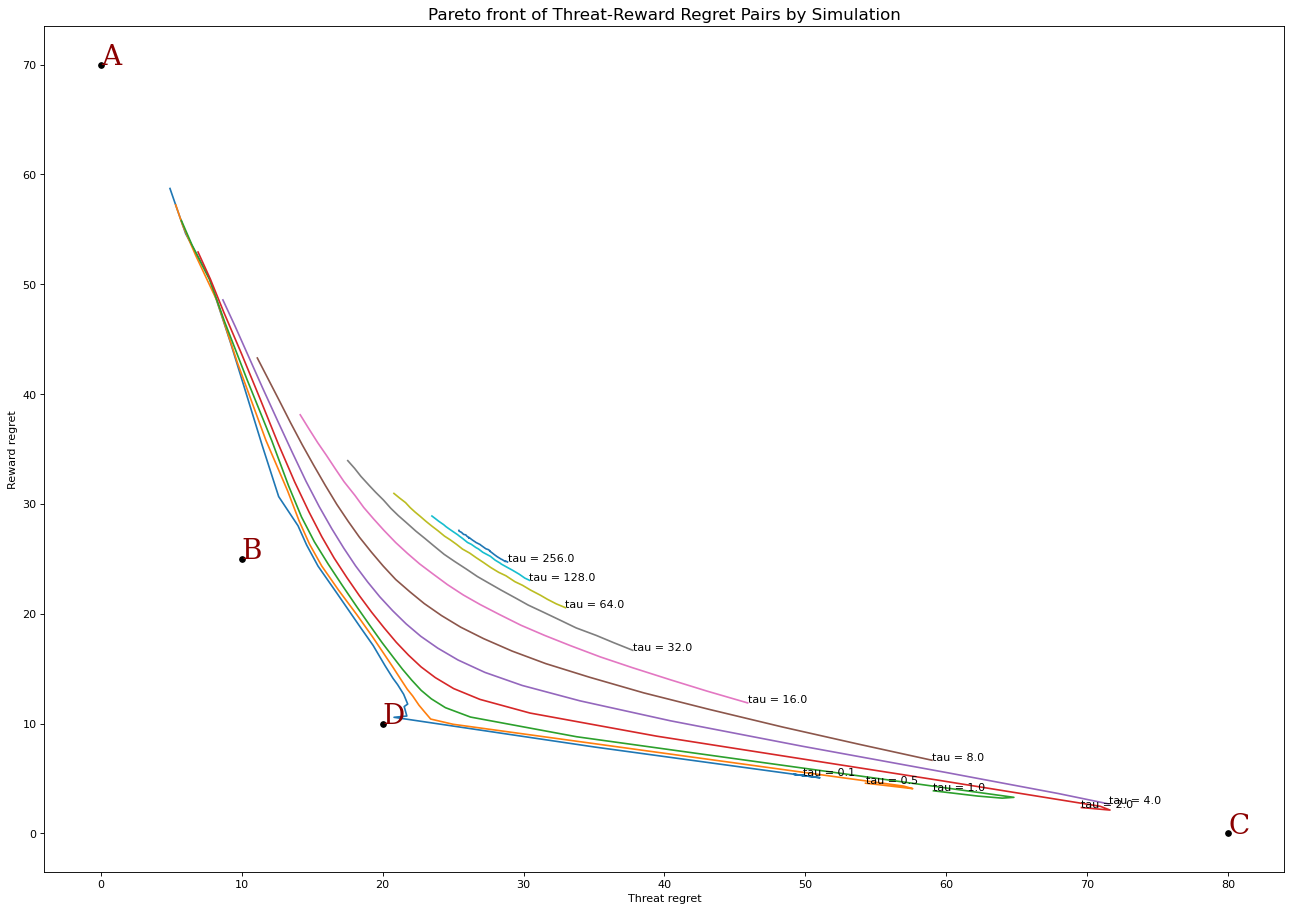

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(20, 14), dpi=80)

   
plt.plot(thr_regret,regret, "kx", marker = "o", markersize = 5, markerfacecolor = "black")
thr_regret = np.round(thr_regret, 2)
regret = np.round(regret, 2)
lbls = ['A ', 'B', 'C', 'D']
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 25,
        }
for i in range(4):
    plt.text(thr_regret[i], regret[i], lbls[i], fontdict = font )


#----------------------plotting the individual policies by w and tau-------------------------------
colors = ['red', 'green', 'blue', 'magenta', 'cyan', 'black', 'yellow', 'white']
print(N)
for n in range(N):
    y = ave_reward_regret[:,n]
   
    x = ave_threat_regret[:,n]
    c = np.random.randint(8)
    plt.plot(x, y, '-')
    plt.text(x[-1], y[-1], "tau = "+str(tau[n]))
plt.xlabel("Threat regret")
plt.ylabel("Reward regret")
plt.title("Pareto front of Threat-Reward Regret Pairs by Simulation" ,fontsize=15)    
plt.show()